# Exploring forward and inverse problems with DC resistivity 

This notebook sets up and runs forward simulations and an inversion for a model with two blocks. You can alter the geometry and physical properties of the blocks and explore the impacts on the data and the inversion result

In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets

# SimPEG inversion machinery
from simpeg import maps, utils

# linear solver
from simpeg.utils.solver_utils import get_default_solver
Solver = get_default_solver()

# DC resistivity modules
from simpeg.electromagnetics import resistivity as dc

In [2]:
from dc_simulation_utils import create_survey, build_mesh, plot_model, plot_data_target_and_background, create_inversion, plot_inversion_results

# Define the survey, model and mesh

In [3]:
# Generate source list for DC survey line
survey = create_survey(
    survey_type="dipole-dipole", 
    end_points=np.r_[-350.0, 450.0], 
    station_spacing=50.0, 
    num_rx_per_src=8,
)

<Axes: xlabel='x1', ylabel='x2'>

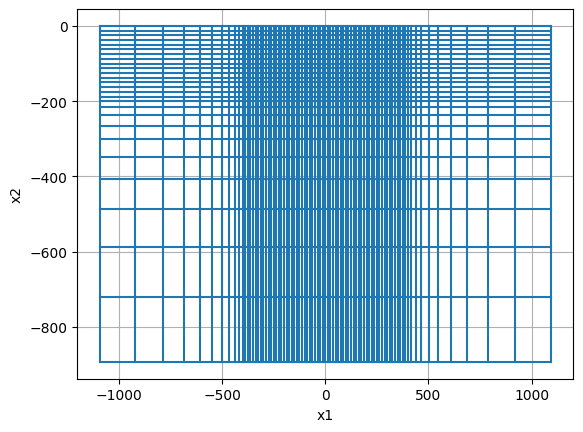

In [4]:
mesh, core_domain_x, core_domain_z = build_mesh(survey)
mesh.plot_grid()

# build our model 

You can change the physical properties and geometry of the blocks

In [5]:
# define the resistivities
rho_background = 100
rho_resistive_block = 1000
rho_conductive_block = 10

# define the geometry of each block
xlim_resistive_block = np.r_[-200, -90]
zlim_resistive_block = np.r_[-100, -50]

xlim_conductive_block = np.r_[200, 90]
zlim_conductive_block = np.r_[-100, -50]

In [6]:
background_model = rho_background * np.ones(mesh.nC)
resistivity_model = background_model.copy()

resistivity_model = utils.model_builder.add_block(
    mesh.cell_centers, resistivity_model, 
    np.r_[xlim_resistive_block.min(), zlim_resistive_block.min()], np.r_[xlim_resistive_block.max(), zlim_resistive_block.max()],
    rho_resistive_block
)
resistivity_model = utils.model_builder.add_block(
    mesh.cell_centers, resistivity_model, 
    np.r_[xlim_conductive_block.min(), zlim_conductive_block.min()], np.r_[xlim_conductive_block.max(), zlim_conductive_block.max()],
    rho_conductive_block
)

(-300.0, 0.0)

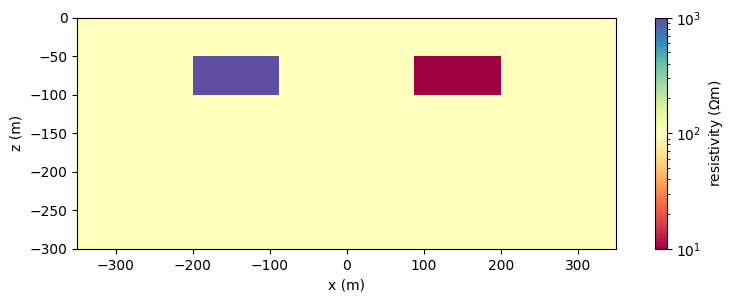

In [7]:
ax = plot_model(mesh, resistivity_model, core_domain_x, core_domain_z)
ax.set_ylim(np.r_[-300, 0])

## Set up and run simulations

In [8]:
noise_level = 0.03  # noise level that we assign to the data

In [9]:
# here, we formulate the simulation in terms of log resistivity
# that way, we enforce that resistivity is positive when we get to the inversion

simulation_dc = dc.Simulation2DNodal(
    mesh, rhoMap=maps.ExpMap(mesh), 
    survey=survey, solver=Solver, storeJ=True
)

In [10]:
# run a simulation for the background data
background_data = simulation_dc.make_synthetic_data(
    np.log(background_model), relative_error=noise_level, add_noise=True
)
# run a simulation for the model with 2 blocks
target_data = simulation_dc.make_synthetic_data(
    np.log(resistivity_model), relative_error=noise_level, add_noise=True
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


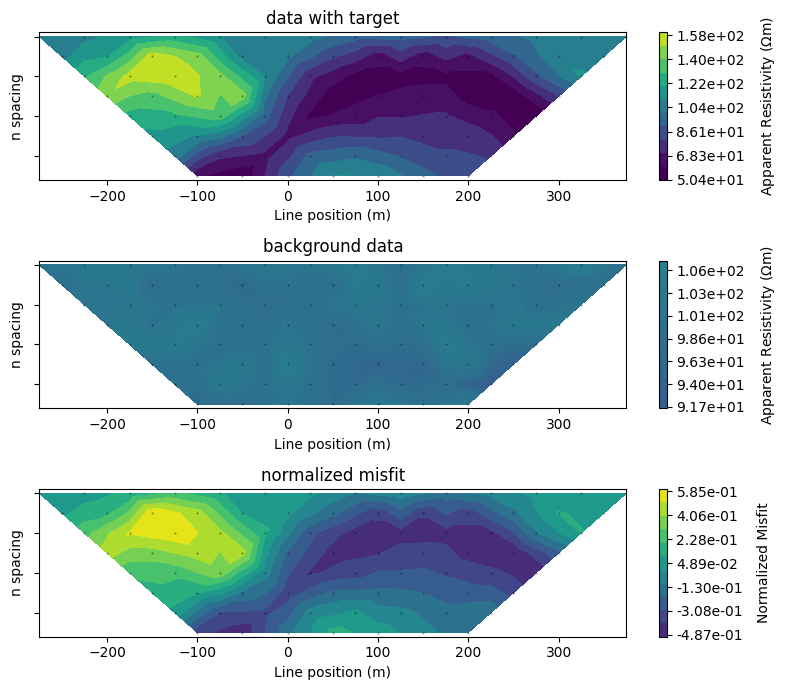

In [11]:
plot_data_target_and_background(
    target_data, background_data
)

# Set up and run the inversion

In [12]:
estimated_relative_error = 0.03  # assume 3% uncertainties on the data 
reference_resistivity = rho_background  # starting and reference model 

alpha_s=1e-2  # weight for the smallness term in the regularization
alpha_x=1  # weight for the smoothness in the x-direction
alpha_y=1  # weight for the smoothness in the y-direction

In [13]:
inv, target_misfit, inversion_log = create_inversion(
    simulation_dc,
    target_data,
    reference_resistivity=reference_resistivity,
    relative_error=estimated_relative_error,
    alpha_s=alpha_s, 
    alpha_x=alpha_x, 
    alpha_y=alpha_y,
    maxIter=20,
    beta0_ratio=1e2,
    beta_cooling_factor=2,
    beta_cooling_rate=1,
)

In [14]:
starting_model = np.log(rho_background) * np.ones(mesh.n_cells)
model_recovered = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.76e+02  6.90e+03  0.00e+00  6.90e+03    2.32e+03      0              
   1  2.38e+02  4.99e+03  1.80e+00  5.41e+03    8.31e+02      0              
   2  1.19e+02  4.05e+03  4.76e+00  4.62e+03    7.02e+02      0   Skip BFGS  
   3  5.95e+01  3.00e+03  1.12e+01  3.67e+03    5.39e+02      0   Skip BFGS  
   4  2.97e+01  2.04e+03  2.30e+01  2.72e+03    3.90e+02      0   Skip BFGS  
   5  1.49e+01  1.25e+03  4.19e+01  1.88e+03    2.64e+02      0   Skip BFG

In [15]:
maxiter = len(inversion_log.outDict)-1
def plot_inversion_results_interactive(iteration):
    plot_inversion_results(
        simulation_dc, target_data, inversion_log, rho_background, 
        core_domain_x, core_domain_z, iteration,
    );

In [16]:
ipywidgets.interact(
    plot_inversion_results_interactive,
    iteration=ipywidgets.IntSlider(min=1, max=maxiter, value=1)
);

interactive(children=(IntSlider(value=1, description='iteration', max=9, min=1), Output()), _dom_classes=('wid…